# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pylab
import statsmodels.api as sm

In [2]:
from io import StringIO
from sklearn.linear_model import LinearRegression
from lmfit.models import LinearModel
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Functions

In [3]:
style_param = {'legend.fontsize': '20',
         'xtick.direction' : 'in',  
         'ytick.direction' : 'in', 
         'xtick.top' : True, 
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
pylab.rcParams.update(style_param)

In [4]:
def add_reference_params(df):
  df["alpha_ref"] = df.alpha[df.LET == 0].iloc[0]
  df["beta_ref"] = df.beta[df.LET == 0].iloc[0]
  df["alpha_ref_err"] = df.alpha_err[df.LET == 0].iloc[0]
  df["beta_ref_err"] = df.beta_err[df.LET == 0].iloc[0]
  return df

# Read data

In [5]:
data_string="""
cell_line	energy	LET	no_points	alpha	alpha_err	beta	beta_err
V79753B	200kV	0	10	0.129	0.012	0.046	0.003
V79753B	5.01	7.7	7	0.289	0.023	0.024	0.006
V79753B	3.2	11.0	7	0.372	0.032	0.036	0.009
V79753B	1.41	20.0	6	0.469	0.029	0.043	0.009
C3H10T1	Cobalt	0	5	0.240	0.06	0.016	0.013
C3H10T1	3.18	11.0	6	0.47	0.06	0.019	0.014
C3H10T1	1.46	19.7	6	0.43	0.06	0.038	0.013
C3H10T1	0.87	28.8	5	0.55	0.12	0.053	0.031
V79379A	240kV	0	6	0.13	0.022	0.048	0.003
V79379A	3.66	10.1	7	0.320	0.058	0.039	0.011
V79379A	1.83	17.8	9	0.45	0.035	0.028	0.006
V79379A	1.07	27.6	8	0.74	0.025	0.011	0.004
HF19	Cs	0	7	0.64	0.02	0	0
HF19	5.04	7.7	6	0.55	0.01	0	0
HF19	1.49	19.5	6	0.54	0.02	0	0
HF19	0.88	29.0	7	0.52	0.01	0	0
M10	Cs	0	8	0.52	0.02	0	0
M10	1.35	21.4	6	0.49	0.02	0	0
M10	4.05	9.1	5	0.5	0.03	0	0
SCC25	Cobalt	0	8	0.57	0.05	0.031	0.012
SCC25	5.04	7.7	5	0.41	0.11	0.092	0.036
SCC25	1.49	19.5	6	0.87	0.05	0	0
SCC25	0.88	29.0	6	0.81	0.03	0	0
SQ20B	Cobalt	0	10	0.13	0.02	0.017	0.002
SQ20B	5.04	7.7	6	0.15	0.05	0.011	0.012
SQ20B	1.49	19.5	6	0.23	0.04	0.004	0.007
SQ20B	0.88	29.0	7	0.57	0.05	0	0
C1-1	Cobalt	0	7	0.23	0.042	0.030	0.008
C1-1	5.04	7.7	6	0.194	0.072	0.023	0.021
C1-1	0.88	29.0	5	0.539	0.027	0	0
DLD1	Cobalt	0	8	0.37	0.09	0.12	0.02
DLD1	5.04	7.7	7	0.47	0.05	0	0
HCT116	Cobalt	0	8	1.39	0.06	0.02	0.02
HCT116	5.04	7.7	8	0.32	0.08	0.06	0.03
H184B5	Cobalt	0	5	0.52	0.02	0	0
H184B5	-	9.1	5	0.5	0.03	0	0
H184B5	-	21.4	5	0.49	0.02	0	0"""

In [6]:
raw_data = pd.read_csv(StringIO(data_string), delimiter='\t')

In [7]:
step1_data = raw_data.groupby('cell_line').apply(add_reference_params)

In [8]:
step2_data = step1_data[step1_data.LET > 0]

In [9]:
fit_data = step2_data.copy()
fit_data['y'] = fit_data.alpha / fit_data.alpha_ref
fit_data['y_centered'] = fit_data.y - 1.0
fit_data['x'] = fit_data.LET / (fit_data.alpha_ref / fit_data.beta_ref)

# Analyze

In [10]:
eq2_model = LinearModel()

In [11]:
params = eq2_model.make_params()
params['intercept'].vary = False
params['intercept'].value = 1.0
params

name,value,initial value,min,max,vary
slope,1.00000000,None,-inf,inf,True
intercept,1.00000000,None,-inf,inf,False


In [12]:
result = eq2_model.fit( fit_data.y, params, x= fit_data.x)

In [13]:
result

In [14]:
model = sm.OLS(fit_data.y_centered, fit_data.x)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             y_centered   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              207.2
Date:                Tue, 29 Jun 2021   Prob (F-statistic):                    1.33e-13
Time:                        00:58:07   Log-Likelihood:                         -18.930
No. Observations:                  26   AIC:                                      39.86
Df Residuals:                      25   BIC:                                      41.12
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

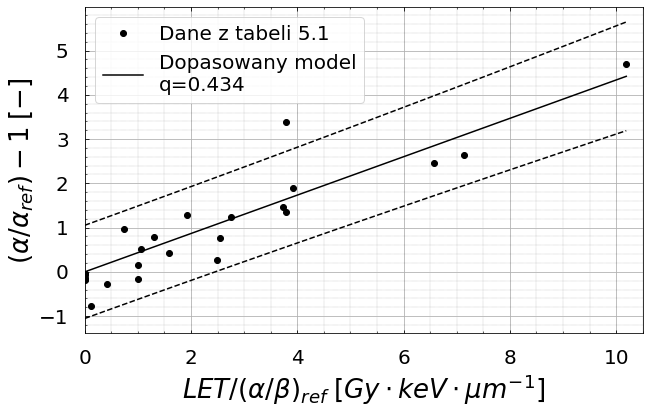

In [15]:
fig,ax = plt.subplots(figsize = (10,6))

fitted_x_for_plot = np.linspace(start = fit_data.x.min(), stop = fit_data.x.max(), num=100)
prstd, iv_l, iv_u = wls_prediction_std(res, fitted_x_for_plot.reshape(-1,1))

ax.plot(fit_data.x, fit_data.y_centered, 'ko', label="Dane z tabeli 5.1")
ax.plot(fitted_x_for_plot, res.predict(fitted_x_for_plot), 'k', label="Dopasowany model\nq=0.434")
ax.plot(fitted_x_for_plot, iv_u, 'k--')
ax.plot(fitted_x_for_plot, iv_l, 'k--')

ax.legend(loc='best');
ax.set_xlim(0,10.5)
   
ax.set_xlabel(r'$LET  /  ({\alpha / \beta})_{ref} \;[Gy \cdot keV \cdot \mu m^{-1}]$')
ax.set_ylabel(r'$(\alpha / \alpha_{ref})-1\;[-]$')
ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')


In [16]:
tmp=pd.DataFrame(list(zip(fit_data.x, fit_data.y_centered,
                         fitted_x_for_plot, res.predict(fitted_x_for_plot))),
                          columns=['data_x','data_y','model_x','model_y'])

tmp.to_csv("results/figure_5_5")
fig.savefig(fname="results/figure_5_5",dpi= 700)

In [17]:
reg = LinearRegression(fit_intercept=False).fit(fit_data.x.values.reshape(-1, 1), fit_data.y_centered.values.reshape(-1, 1))

In [18]:
reg.coef_

array([[0.43353039]])